In [16]:
import pickle
import numpy as np
import pandas as pd

In [17]:
df = pd.read_csv('gang_csv.csv')
df.head()

,1220029700,1220032100,1220033000,1220024600,1220028200,1210030000,1220025300,1220029200,1220034000,1220034300,...,1220026300,1220033400,1220025200,1220033100,1220031800,1220033300,1220031000,1220034600,1220032800,1220026800
0,25.19,29.65,28.08,25.14,20.30,36.73,28.74,31.59,32.78,27.48,...,31.11,31.87,25.61,35.04,36.00,31.82,25.18,24.80,17.00,29.09
1,26.96,24.27,26.63,26.65,20.49,36.74,26.28,28.80,30.56,26.95,...,30.26,34.42,26.18,34.95,36.61,30.24,25.07,21.33,26.80,28.95
2,26.20,28.07,27.76,24.94,22.35,32.30,27.88,32.74,32.22,35.34,...,33.27,24.70,24.06,31.08,37.30,27.94,24.16,30.84,24.68,31.14
3,26.72,23.98,26.34,27.54,24.68,40.67,29.85,27.55,28.83,31.98,...,32.80,30.08,26.93,35.77,34.74,27.34,25.15,27.20,24.02,33.40
4,27.21,24.11,26.63,24.71,19.57,32.51,26.93,29.77,30.60,28.39,...,30.48,26.82,26.36,32.22,38.51,28.47,23.82,30.69,23.19,33.97


In [18]:
adj_matrix = np.load('adj_matrix.npy')

In [19]:
with open('./edges_index.pickle', 'rb') as fr:
    edge_index = pickle.load(fr)

In [20]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

In [61]:
class LSTM(nn.Module):
    def __init__(self, num_series, hidden):
        '''
        LSTM model with output layer to generate predictions.
        Args:
          num_series: number of input time series.
          hidden: number of hidden units.
        '''
        super(LSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up network.
        self.lstm = nn.LSTM(num_series, hidden, batch_first=True)
        self.lstm.flatten_parameters()
        self.linear = nn.Conv1d(hidden, 1, 1)

    def init_hidden(self, batch):
        '''Initialize hidden states for LSTM cell.'''
        device = self.lstm.weight_ih_l0.device
        return (torch.zeros(1, batch, self.hidden, device=device),
                torch.zeros(1, batch, self.hidden, device=device))

    def forward(self, X, hidden=None):
        # Set up hidden state.
        if hidden is None:
            hidden = self.init_hidden(X.shape[0])

        # Apply LSTM.
        X, hidden = self.lstm(X, hidden)

        # Calculate predictions using output layer.
        X = X.transpose(2, 1)
        X = self.linear(X)
        return X.transpose(2, 1), hidden


In [21]:
class cLSTM(nn.Module):
    
    def __init__(self, num_series, hidden):
        super(cLSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up networks.
        self.networks = nn.ModuleList([
            LSTM(num_series, hidden) for _ in range(num_series)])
    
    def forward(self, X, hidden=None):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
          hidden: hidden states for LSTM cell.
        '''
        if hidden is None:
            hidden = [None for _ in range(self.p)]
        pred = [self.networks[i](X, hidden[i])
                for i in range(self.p)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden

    def GC(self, threshold=True):
        '''
        Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.norm(net.lstm.weight_ih_l0, dim=0)
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC

In [22]:
class cLSTMSparse(nn.Module):
    def __init__(self, num_series, sparsity, hidden):
        '''
        cLSTM model that only uses specified interactions.
        Args:
          num_series: dimensionality of multivariate time series.
          sparsity: torch byte tensor indicating Granger causality, with size
            (num_series, num_series).
          hidden: number of units in LSTM cell.
        '''
        super(cLSTMSparse, self).__init__()
        self.p = num_series
        self.hidden = hidden
        self.sparsity = sparsity

        # Set up networks.
        self.networks = nn.ModuleList([
            LSTM(int(torch.sum(sparsity[i].int())), hidden)
            for i in range(num_series)])

    def forward(self, X, hidden=None):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
          hidden: hidden states for LSTM cell.
        '''
        if hidden is None:
            hidden = [None for _ in range(self.p)]
        pred = [self.networks[i](X[:, :, self.sparsity[i]], hidden[i])
                for i in range(self.p)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden

In [23]:
def prox_update(network, lam, lr):
    '''Perform in place proximal update on first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    norm = torch.norm(W, dim=0, keepdim=True)
    W.data = ((W / torch.clamp(norm, min=(lam * lr)))
              * torch.clamp(norm - (lr * lam), min=0.0))
    network.lstm.flatten_parameters()

In [24]:
def regularize(network, lam):
    '''Calculate regularization term for first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    return lam * torch.sum(torch.norm(W, dim=0))

In [25]:
def ridge_regularize(network, lam):
    '''Apply ridge penalty at linear layer and hidden-hidden weights.'''
    return lam * (
        torch.sum(network.linear.weight ** 2) +
        torch.sum(network.lstm.weight_hh_l0 ** 2))

In [26]:
def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params


In [27]:
def arrange_input(data, context):
    '''
    Arrange a single time series into overlapping short sequences.
    Args:
      data: time series of shape (T, dim).
      context: length of short sequences.
    '''
    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(len(data) - context, context, data.shape[1],
                        dtype=torch.float32, device=data.device)
    target = torch.zeros(len(data) - context, context, data.shape[1],
                         dtype=torch.float32, device=data.device)
    for i in range(context):
        start = i
        end = len(data) - context + i
        input[:, i, :] = data[start:end]
        target[:, i, :] = data[start+1:end+1]
    return input.detach(), target.detach()

In [29]:
def train_model_gista(clstm, X, context, lam, lam_ridge, lr, max_iter,
                      check_every=50, r=0.8, lr_min=1e-8, sigma=0.5,
                      monotone=False, m=10, lr_decay=0.5,
                      begin_line_search=True, switch_tol=1e-3, verbose=1):
    '''
    Train cLSTM model with GISTA.
    Args:
      clstm: clstm model.
      X: tensor of data, shape (batch, T, p).
      context: length for short overlapping subsequences.
      lam: parameter for nonsmooth regularization.
      lam_ridge: parameter for ridge regularization on output layer.
      lr: learning rate.
      max_iter: max number of GISTA iterations.
      check_every: how frequently to record loss.
      r: for line search.
      lr_min: for line search.
      sigma: for line search.
      monotone: for line search.
      m: for line search.
      lr_decay: for adjusting initial learning rate of line search.
      begin_line_search: whether to begin with line search.
      switch_tol: tolerance for switching to line search.
      verbose: level of verbosity (0, 1, 2).
    '''
    p = clstm.p
    clstm_copy = deepcopy(clstm)
    loss_fn = nn.MSELoss(reduction='mean')
    lr_list = [lr for _ in range(p)]

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # Calculate full loss.
    mse_list = []
    smooth_list = []
    loss_list = []
    for i in range(p):
        net = clstm.networks[i]
        pred, _ = net(X)
        mse = loss_fn(pred[:, :, 0], Y[:, :, i])
        ridge = ridge_regularize(net, lam_ridge)
        smooth = mse + ridge
        mse_list.append(mse)
        smooth_list.append(smooth)
        with torch.no_grad():
            nonsmooth = regularize(net, lam)
            loss = smooth + nonsmooth
            loss_list.append(loss)

    # Set up lists for loss and mse.
    with torch.no_grad():
        loss_mean = sum(loss_list) / p
        mse_mean = sum(mse_list) / p
    train_loss_list = [loss_mean]
    train_mse_list = [mse_mean]

    # For switching to line search.
    line_search = begin_line_search

    # For line search criterion.
    done = [False for _ in range(p)]
    assert 0 < sigma <= 1
    assert m > 0
    if not monotone:
        last_losses = [[loss_list[i]] for i in range(p)]

    for it in range(max_iter):
        # Backpropagate errors.
        sum([smooth_list[i] for i in range(p) if not done[i]]).backward()

        # For next iteration.
        new_mse_list = []
        new_smooth_list = []
        new_loss_list = []

        # Perform GISTA step for each network.
        for i in range(p):
            # Skip if network converged.
            if done[i]:
                new_mse_list.append(mse_list[i])
                new_smooth_list.append(smooth_list[i])
                new_loss_list.append(loss_list[i])
                continue

            # Prepare for line search.
            step = False
            lr_it = lr_list[i]
            net = clstm.networks[i]
            net_copy = clstm_copy.networks[i]

            while not step:
                # Perform tentative ISTA step.
                for param, temp_param in zip(net.parameters(),
                                             net_copy.parameters()):
                    temp_param.data = param - lr_it * param.grad

                # Proximal update.
                prox_update(net_copy, lam, lr_it)

                # Check line search criterion.
                pred, _ = net_copy(X)
                mse = loss_fn(pred[:, :, 0], Y[:, :, i])
                ridge = ridge_regularize(net_copy, lam_ridge)
                smooth = mse + ridge
                with torch.no_grad():
                    nonsmooth = regularize(net_copy, lam)
                    loss = smooth + nonsmooth
                    tol = (0.5 * sigma / lr_it) * sum(
                        [torch.sum((param - temp_param) ** 2)
                         for param, temp_param in
                         zip(net.parameters(), net_copy.parameters())])

                comp = loss_list[i] if monotone else max(last_losses[i])
                if not line_search or (comp - loss) > tol:
                    step = True
                    if verbose > 1:
                        print('Taking step, network i = %d, lr = %f'
                              % (i, lr_it))
                        print('Gap = %f, tol = %f' % (comp - loss, tol))

                    # For next iteration.
                    new_mse_list.append(mse)
                    new_smooth_list.append(smooth)
                    new_loss_list.append(loss)

                    # Adjust initial learning rate.
                    lr_list[i] = (
                        (lr_list[i] ** (1 - lr_decay)) * (lr_it ** lr_decay))

                    if not monotone:
                        if len(last_losses[i]) == m:
                            last_losses[i].pop(0)
                        last_losses[i].append(loss)
                else:
                    # Reduce learning rate.
                    lr_it *= r
                    if lr_it < lr_min:
                        done[i] = True
                        new_mse_list.append(mse_list[i])
                        new_smooth_list.append(smooth_list[i])
                        new_loss_list.append(loss_list[i])
                        if verbose > 0:
                            print('Network %d converged' % (i + 1))
                        break

            # Clean up.
            net.zero_grad()

            if step:
                # Swap network parameters.
                clstm.networks[i], clstm_copy.networks[i] = net_copy, net

        # For next iteration.
        mse_list = new_mse_list
        smooth_list = new_smooth_list
        loss_list = new_loss_list

        # Check if all networks have converged.
        if sum(done) == p:
            if verbose > 0:
                print('Done at iteration = %d' % (it + 1))
            break

        # Check progress
        if (it + 1) % check_every == 0:
            with torch.no_grad():
                loss_mean = sum(loss_list) / p
                mse_mean = sum(mse_list) / p
                ridge_mean = (sum(smooth_list) - sum(mse_list)) / p
                nonsmooth_mean = (sum(loss_list) - sum(smooth_list)) / p

            train_loss_list.append(loss_mean)
            train_mse_list.append(mse_mean)

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Total loss = %f' % loss_mean)
                print('MSE = %f, Ridge = %f, Nonsmooth = %f'
                      % (mse_mean, ridge_mean, nonsmooth_mean))
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(clstm.GC().float())))

            # Check whether loss has increased.
            if not line_search:
                if train_loss_list[-2] - train_loss_list[-1] < switch_tol:
                    line_search = True
                    if verbose > 0:
                        print('Switching to line search')

    return train_loss_list, train_mse_list


In [30]:
def train_model_adam(clstm, X, context, lr, max_iter, lam=0, lam_ridge=0,
                     lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(clstm.parameters(), lr=lr)
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    for it in range(max_iter):
        # Calculate loss.
        pred = [clstm.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])

        # Add penalty term.
        if lam > 0:
            loss = loss + sum([regularize(net, lam) for net in clstm.networks])

        if lam_ridge > 0:
            loss = loss + sum([ridge_regularize(net, lam_ridge)
                               for net in clstm.networks])

        # Take gradient step.
        loss.backward()
        optimizer.step()
        clstm.zero_grad()

        # Check progress.
        if (it + 1) % check_every == 0:
            mean_loss = loss / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list

In [31]:
def train_model_ista(clstm, X, context, lr, max_iter, lam=0, lam_ridge=0,
                     lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    # Calculate smooth error.
    pred = [clstm.networks[i](X)[0] for i in range(p)]
    loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
    ridge = sum([ridge_regularize(net, lam_ridge) for net in clstm.networks])
    smooth = loss + ridge

    for it in range(max_iter):
        # Take gradient step.
        smooth.backward()
        for param in clstm.parameters():
            param.data -= lr * param.grad

        # Take prox step.
        if lam > 0:
            for net in clstm.networks:
                prox_update(net, lam, lr)

        clstm.zero_grad()

        # Calculate loss for next iteration.
        pred = [clstm.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
        ridge = sum([ridge_regularize(net, lam_ridge)
                     for net in clstm.networks])
        smooth = loss + ridge

        # Check progress.
        if (it + 1) % check_every == 0:
            # Add nonsmooth penalty.
            nonsmooth = sum([regularize(net, lam) for net in clstm.networks])
            mean_loss = (smooth + nonsmooth) / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(clstm.GC().float())))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list

In [32]:
def train_unregularized(clstm, X, context, lr, max_iter, lookback=5,
                        check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(clstm.parameters(), lr=lr)
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    for it in range(max_iter):
        # Calculate loss.
        pred, hidden = clstm(X)
        loss = sum([loss_fn(pred[:, :, i], Y[:, :, i]) for i in range(p)])

        # Take gradient step.
        loss.backward()
        optimizer.step()
        clstm.zero_grad()

        # Check progress.
        if (it + 1) % check_every == 0:
            mean_loss = loss / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list

In [33]:
import matplotlib.pyplot as plt

In [37]:
from scipy.integrate import odeint

In [66]:
device = torch.device('cuda')

In [54]:
X[0][1]

tensor([ 2.3833,  4.3567,  7.5971, -2.8582, -4.1893, -1.9402,  9.7620,  4.7616,
        -4.7465,  2.9787], device='cuda:0')

In [56]:
GC = adj_matrix
X_np = df.values

In [58]:
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [62]:
clstm = cLSTM(X.shape[-1], hidden=100).cuda(device=device)

In [67]:
train_loss_list = train_model_adam(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,
    check_every=100)

C:\Users\chanyoung\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


----------Iter = 100----------
Loss = 65.181747
----------Iter = 200----------
Loss = 41.225868
----------Iter = 300----------
Loss = 30.051872
----------Iter = 400----------
Loss = 25.131838
----------Iter = 500----------
Loss = 24.186506
----------Iter = 600----------
Loss = 23.250666
----------Iter = 700----------
Loss = 23.382753
----------Iter = 800----------
Loss = 22.206722
----------Iter = 900----------
Loss = 23.124399
----------Iter = 1000----------
Loss = 22.762918
----------Iter = 1100----------
Loss = 21.270380
----------Iter = 1200----------
Loss = 20.816652
----------Iter = 1300----------
Loss = 22.242414
----------Iter = 1400----------
Loss = 22.193954
----------Iter = 1500----------
Loss = 19.514540
----------Iter = 1600----------
Loss = 22.673132
----------Iter = 1700----------
Loss = 18.854631
----------Iter = 1800----------
Loss = 21.596512
----------Iter = 1900----------
Loss = 20.608078
----------Iter = 2000----------
Loss = 22.501295
----------Iter = 2100--------

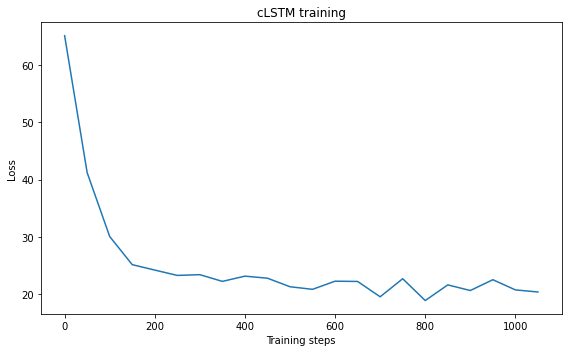

In [68]:

# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

True variable usage = 20.07%
Estimated variable usage = 100.00%
Accuracy = 20.07%


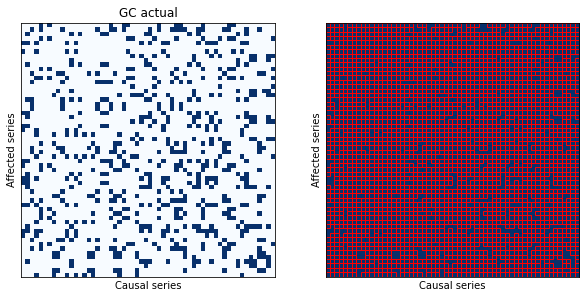

In [69]:
# Check learned Granger causality
GC_est = clstm.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()